## 1.- Import standard libraries

In [1]:
# Import custom libraries from local folder.
from importlib import reload
import os
import sys
sys.path.append("..")

# Import nn module from torch to replicate kessler tool
import torch.nn as nn

# Import utils library containing miscellaneous functions/classes
from scalib import utils

# Import library to import Kelvins challlenge data
from scalib.eda import kelvins_challenge_events

# Import SCALIB modules for NN development
import scalib.xnn as xnn            # NN models
import scalib.cells as cell         # RNN cell architectures
import scalib.layers as layers      # RNN layers

# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

print(utils.cwd)

/Users/jjrr/Documents/SCA-Project/scalib


## 2.- Data preparation

In [2]:
#As an example, we first show the case in which the data comes from the Kelvins competition.
#For this, we built a specific converter that takes care of the conversion from Kelvins format
#to standard CDM format (the data can be downloaded at https://kelvins.esa.int/collision-avoidance-challenge/data/):
filepath = os.path.join(utils.cwd,'data','esa-challenge','train_data.csv')

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(filepath,
            drop_features = ['c_rcs_estimate', 't_rcs_estimate'], 
            num_events = 2000)

# Get features to train the model.
nn_features = events.common_features(only_numeric=True)

# Define input and output size of the RNN model.
input_size = len(nn_features)
output_size = len(nn_features)

# Split data into a test set (5% of the total number of events)
len_test_set=int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test=events[-len_test_set:]
print('\nTest data:', events_test)

# Get events used for training and validation:
# - Training set: Used to train the model and backpropagate the loss.
# - Validation set: Used to compute the loss so that hyperparameters can be 
#   adjusted.
events_train_and_val=events[:-len_test_set]
print('Training and validation data:', events_train_and_val)

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scalib/data/esa-challenge/train_data.csv

KELVINS DATASET IMPORT:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:10s |  192.87   | Dataset imported (2000 events).         

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:31s |   63.40   | Pandas DataFrame saved.                                 

Test data: ConjunctionEventsDataset(Events:100 | Number of CDMs per event: 1 (min), 22 (max), 12.80 (mean))
Training and validation data: ConjunctionEventsDataset(Events:1900 | Number of CDMs per event: 1 (min), 22 (max), 13.45 (mean))


## 3.- Recurrent Neural Network model configuration

### 3.1.- RNN layer and cell architecture definition

In [3]:
# Initialize dictionary of pytorch modules
networks = nn.ModuleDict({})

count_params = lambda x: sum(p.numel() for p in x.parameters())

# Initialize parameters
num_layers = 2      # Number of stacked LSTM layers
dropout = 0.2       # Dropout probability between layers
hidden_size = 264   # Hidden size
batch_size = 15

In [4]:
hidden_size = 264   # Hidden size
# Initialize LSTM architecture using custom cell
networks.update({'kessler':
                 nn.ModuleDict({'lstm': nn.LSTM(input_size = input_size,
                                        batch_first = True,
                                        hidden_size = hidden_size,
                                        num_layers = num_layers,
                                        dropout = dropout),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(hidden_size, output_size)
                                })
                })

#### 3.1.2.- LSTM layer with *Vanilla* cell architecture ([Kessler](https://github.com/kesslerlib/kessler.git)'s configuration)

In [5]:
hidden_size = 264   # Hidden size
# Initialize LSTM architecture using custom cell
networks.update({'lstm_vanilla':
                 nn.ModuleDict({'lstm': layers.LSTM(input_size = input_size,
                                         batch_first = True, 
                                         hidden_size = hidden_size, 
                                         num_layers = num_layers,
                                         dropout = dropout,
                                         cell = cell.LSTM_Vanilla),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(hidden_size, output_size)
                                })
                })

#### 3.1.3.- LSTM layer with *SLIMX* cell architecture (*x* = 1, 2, or 3)

In [6]:
# Initialize LSTM architecture using SLIMx cell architecture. 
# Three options are available by passing the extra parameter slim_version
# 1 - Gates contain hidden states weights and bias (Wh + b). Default value.
# 2 - Gates contain hidden states weights only (Wh).
# 3 - Gates contain learnable bias only (b).
reload(cell)
reload(layers)
hidden_sizes = [313, 313, 897]
for v in [1, 2, 3]:
    networks.update({f'lstm_slim{v}':
                     nn.ModuleDict({'lstm': layers.LSTM(input_size = input_size, 
                                            hidden_size = hidden_sizes[v-1],
                                            cell = cell.LSTM_SLIMX, 
                                            num_layers = num_layers if v < 3 \
                                                                    else 1,
                                            dropout = dropout,
                                            **dict(version = v)),
                                    'dropout': nn.Dropout(p = dropout),
                                    'relu': nn.ReLU(),
                                    'linear': nn.Linear(hidden_sizes[v-1], output_size)
                                    })
                    })

/Users/jjrr/Documents/SCA-Project/scalib/notebooks/../scalib/layers.py:192: UserWarning: 
Dropout parameter in LSTM class adds dropout layers after all but last recurrent layer. 
It expects num_layers greater > 1, but got num_layers = 1.
  warnings.warn(


#### 3.1.4.- LSTM layer with no *X* gate (NXG) in cell architecture (*X* = Input, Forget or Output)

In [7]:
# Initialize LSTM architecture using NXG cell architecture (one of the 
# information gates within the cell is cancelled out.
hidden_sizes = [306, 306, 306] 
for g, gate in enumerate(['input', 'output', 'forget']):
    networks.update({f'lstm_n{gate[0]}g':
                     nn.ModuleDict({'lstm': layers.LSTM(input_size = input_size, 
                                            hidden_size = hidden_sizes[g],
                                            cell = cell.LSTM_NXG, 
                                            num_layers = num_layers,
                                            dropout = dropout,
                                            **dict(drop_gate = gate)),
                                    'dropout': nn.Dropout(p = dropout),
                                    'relu': nn.ReLU(),
                                    'linear': nn.Linear(hidden_sizes[g], output_size)
                                    })
                    })

#### 3.1.5.- LSTM layer with no activation function at *X* gate (NXGAF) in cell architecture (*X* = Input, Forget, Output, or Cell)

In [8]:
# Initialize LSTM architecture using NXG cell architecture (one of the 
# information gates within the cell is cancelled out.
hidden_size = 264   # Hidden size  
for gate in ['input', 'output', 'forget']:
    networks.update({f'lstm_n{gate[0]}gaf':
                     nn.ModuleDict({'lstm': layers.LSTM(input_size = input_size, 
                                            hidden_size = hidden_size,
                                            cell = cell.LSTM_NXGAF, 
                                            num_layers = num_layers,
                                            dropout = dropout,
                                            **dict(naf_gate = gate)),
                                    'dropout': nn.Dropout(p = dropout),
                                    'relu': nn.ReLU(),
                                    'linear': nn.Linear(hidden_size, output_size)
                                    }),
                    
                    })

#### 3.1.6.- LSTM-Attention-LSTM layer

In [9]:
# Initialize Self-Attention network with LSTM Vanilla encoders
attention_hs = 230
networks.update({f'lstm_attn-vanilla':
                 nn.ModuleDict({'lstm_encoder': 
                                    layers.LSTM(
                                        input_size = input_size,
                                        hidden_size = attention_hs,
                                        cell = cell.LSTM_Vanilla),
                                'attention': 
                                    layers.SelfAttentionLayer(
                                        input_size = attention_hs),
                                'lstm_decoder': 
                                    layers.LSTM(
                                        input_size = attention_hs, 
                                        hidden_size = attention_hs,
                                        cell = cell.LSTM_Vanilla),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(attention_hs, output_size)
                                })
                })

In [10]:
# Initialize LSTM architecture using custom cell
reload(layers)
reload(cell)
hidden_size = 306
networks.update({'gru_vanilla':
                 nn.ModuleDict({'gru': layers.GRU(input_size = input_size,
                                         batch_first = True, 
                                         hidden_size = hidden_size, 
                                         num_layers = num_layers,
                                         dropout = dropout,
                                         cell = cell.GRU_Vanilla),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(hidden_size, output_size)
                                })
                })

In [11]:
# Initialize GRU architecture using SLIMx cell architecture. 
# Three options are available by passing the extra parameter slim_version
# 1 - Gates contain hidden states weights and bias (Wh + b). Default value.
# 2 - Gates contain hidden states weights only (Wh).
# 3 - Gates contain learnable bias only (b).
reload(cell)
reload(layers)
hidden_sizes = [354, 354, 897]
for v in [1, 2, 3]:
    networks.update({f'gru_slim{v}':
                     nn.ModuleDict({'gru': layers.GRU(input_size = input_size, 
                                            hidden_size = hidden_sizes[v-1],
                                            cell = cell.GRU_SLIMX, 
                                            num_layers = num_layers if v < 3 \
                                                                    else 1,
                                            dropout = dropout,
                                            **dict(version = v)),
                                    'dropout': nn.Dropout(p = dropout),
                                    'relu': nn.ReLU(),
                                    'linear': nn.Linear(hidden_sizes[v-1], output_size)
                                    })
                    })

/Users/jjrr/Documents/SCA-Project/scalib/notebooks/../scalib/layers.py:405: UserWarning: 
Dropout parameter in LSTM class adds dropout layers after all but last recurrent layer. 
It expects num_layers greater > 1, but got num_layers = 1.
  warnings.warn(


In [12]:
# Initialize GRU architecture using MUTx cell architecture. 
# Three options are available by passing the extra parameter slim_version
# 1 - Gates contain hidden states weights and bias (Wh + b). Default value.
# 2 - Gates contain hidden states weights only (Wh).
# 3 - Gates contain learnable bias only (b).
reload(cell)
reload(layers)
hidden_size = 306

networks.update({f'gru_mut3':
                    nn.ModuleDict({'gru': layers.GRU(input_size = input_size, 
                                        hidden_size = hidden_size,
                                        cell = cell.GRU_MUTX, 
                                        num_layers = num_layers,
                                        dropout = dropout,
                                        **dict(version = 3)),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(hidden_size, 
                                                    output_size)
                                })
                })

In [17]:
# Initialize Self-Attention network with LSTM Vanilla encoders
attention_hs = 256
networks.update({f'gru_attn-vanilla':
                 nn.ModuleDict({'gru_encoder': 
                                    layers.GRU(
                                        input_size = input_size,
                                        hidden_size = attention_hs,
                                        cell = cell.GRU_Vanilla),
                                'attention': 
                                    layers.SelfAttentionLayer(
                                        input_size = attention_hs),
                                'gru_decoder': 
                                    layers.GRU(
                                        input_size = attention_hs, 
                                        hidden_size = attention_hs,
                                        cell = cell.GRU_Vanilla),
                                'dropout': nn.Dropout(p = dropout),
                                'relu': nn.ReLU(),
                                'linear': nn.Linear(attention_hs, output_size)
                                })
                })

### 3.2.- Model instanciation

In [18]:
# Print number of parameters per model
print('{:^12} | {:^11} | {:^8} | {:<}\n{}'.format('Parameters', 
                                                   'Hidden size', 
                                                   'Layers',
                                                   'Network', '-'*45))
for name, network in networks.items():

    # Get number of parameters in the model.
    num_params = sum(p.numel() for p in network.parameters())
    for layer_name, layer in network.items():
        if any(arch in layer_name for arch in ['lstm', 'gru']):
            hs = layer.hidden_size
            nl = layer.num_layers
            break

    print('{:^12,} | {:^11} | {:^8} | {:<}'.format(num_params, hs, nl, name.upper()))

 Parameters  | Hidden size |  Layers  | Network
---------------------------------------------
  927,762    |     264     |    2     | KESSLER
  927,762    |     264     |    2     | LSTM_VANILLA
  925,607    |     313     |    2     | LSTM_SLIM1
  923,729    |     313     |    2     | LSTM_SLIM2
  926,667    |     897     |    1     | LSTM_SLIM3
  927,246    |     306     |    2     | LSTM_NIG
  927,246    |     306     |    2     | LSTM_NOG
  927,246    |     306     |    2     | LSTM_NFG
  927,762    |     264     |    2     | LSTM_NIGAF
  927,762    |     264     |    2     | LSTM_NOGAF
  927,762    |     264     |    2     | LSTM_NFGAF
  926,966    |     230     |    1     | LSTM_ATTN-VANILLA
  925,410    |     306     |    2     | GRU_VANILLA
  926,130    |     354     |    2     | GRU_SLIM1
  924,714    |     354     |    2     | GRU_SLIM2
  925,770    |     897     |    1     | GRU_SLIM3
  927,246    |     306     |    2     | GRU_MUT3
  922,178    |     256     |    1     | GRU

In [105]:
import torch
reload(xnn)

# Print model.
network_name = 'gru_slim3'
network = networks[network_name]

# print(f'\n{network}\n')

# Initialize model.
model = xnn.ConjunctionEventForecaster(layers = network, features = nn_features)

# Iterate over network to get the parameters.
for name, layer in network.items():
    if network_name.split('_')[0] in name:
        layer.hidden_size
        filename = f'cef_{network_name}_' + \
                   f'hs{layer.hidden_size}_' + \
                   f'nl{layer.num_layers}_bs{batch_size}_parameters'
        break
        
filepath_model = os.path.join(utils.cwd, 'models', filename)

# torch.save(network, filepath_model + '_network')

print(f'Model filename: {filename}')

Model filename: cef_gru_slim3_hs897_nl1_bs15_parameters


### Model training

In [106]:
# Start training
model.learn(events_train_and_val, epochs = 10, lr = 5e-4, batch_size = batch_size, 
            device = 'cpu', event_samples_for_stats = 2000, 
            filepath_model = filepath_model, epoch_step_checkpoint = 5)

Number of learnable parameters of the model: 925,770

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1900/1900)| 00h:00m:00s | 82346.63  | Pandas DataFrame saved.                                 

Model parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/models/cef_gru_slim3_hs897_nl1_bs15_parameters
 - Total epochs       = 10
 - Total iterations   = 1040
 - Validation loss    = 1.1263e-01
 - Last learning rate = 1.0000e-03


TRAINING FORECASTING MODEL:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1040/1040)| 00h:13m:23s |   1.29    | Batch 104/104 | Loss -> Train = 1.4348e-01 : Valid = 1.0419e-01

Saving model parameters ... Done.


In [107]:
import pandas as pd
display(pd.Series(model._learn_results['validation_loss'],
                  model._learn_results['epoch'])
                  .drop_duplicates(keep='first')
                  .sort_index(ascending=False).head(5))

20    0.104194
19    0.104015
18    0.105024
17    0.105070
16    0.104002
dtype: float64

##### Training vs validation loss

In [ ]:
# Plot MSE loss throughout iterations.
model.plot_loss(filepath = os.path.join(utils.cwd, 'images', filename + '.pdf'), 
                log_scale = False, 
                plot_lr = False)

##### Conjunction event forecasting

In [ ]:
# Take a single event from test dataset and remove the last CDM.
event_idx = 2
event = events_test[event_idx]
event_beginning = event[0:len(event)-1]

# Print information about the event to forecast.
print(f'Forecasting next CDM from previous {len(event)} CDM(s)...')

# Predict the evolution of the conjunction event until TCA or the number of CDMs
# is max_length.
event_evolution = model.predict_event(event = event_beginning, 
                                      num_samples = 10, 
                                      max_length = 14)

# List of features to predict.
features = ['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CT_T']

# Plot prediction in red
axs = event_evolution.plot_features(features = features, return_axs = True, 
                                    linewidth = 0.1, color = 'red', alpha=0.33, 
                                    label = 'Prediction')
#and the ground truth value in blue:
event.plot_features(features=features, axs=axs, label='Actual', legend = True)

## Comparing models performance

In [108]:
import pandas as pd
import torch
def get_models_performance(folderpath:str, referential_network:str):

    # Initialize dictionary to keep models performance.
    data = dict()

    # Iterate over all elements in the folder
    for f in os.listdir(folderpath):

        # Check if it is a model file.
        if not os.path.isfile(os.path.join(folderpath, f)) or not \
            (f[:3]=='cef' and f.split('_')[-1]=='parameters'): continue
        
        filename = '_'.join(f.split('_')[1:-1])

        parameters = torch.load(os.path.join(folderpath, 
                                             f'cef_{filename}_parameters'))

        num_params = parameters['num_params'] if 'num_params' in parameters.keys() else 0
        results = parameters['learn_results']

        data[filename.upper()] = [num_params,
                                    results['validation_loss'][-1],
                                    results['total_iterations'][-1],
                                    results['epoch'][-1],
                                    results['learning_rate'][-1]]

    columns = ['PARAMETERS', 'VALIDATION_LOSS', 'ITERATIONS', 
               'EPOCHS', 'LEARNING_RATE']
    df = pd.DataFrame.from_dict(columns = columns, data=data, orient='index')
    if referential_network is not None:
        ref_loss = df.loc[referential_network]['VALIDATION_LOSS']
        df['RELATIVE_LOSS'] = (df['VALIDATION_LOSS']-ref_loss)/ref_loss

    return df

df = get_models_performance(os.path.join(utils.cwd,'models'),
                               referential_network='LSTM_VANILLA_HS264_NL2_BS15')

# Save results in a CSV file.
df.to_csv('rnn_networks_performance.csv')

display(df.sort_values(by=['VALIDATION_LOSS'], ascending=True))

,PARAMETERS,VALIDATION_LOSS,ITERATIONS,EPOCHS,LEARNING_RATE,RELATIVE_LOSS
GRU_ATTN-VANILLA_HS256_NL1_BS15,922178,0.080716,2080,20,0.0005,-0.408766
LSTM_ATTN-VANILLA_HS230_NL1_BS15,926966,0.101004,2080,20,0.0005,-0.260162
GRU_SLIM3_HS897_NL1_BS15,925770,0.104194,2080,20,0.0005,-0.236797
LSTM_SLIM3_HS897_NL1_BS15,926667,0.111609,2080,20,0.0005,-0.182481
GRU_SLIM1_HS354_NL2_BS15,926130,0.130049,2080,20,0.0005,-0.047410
LSTM_NOG_HS306_NL2_BS15,927246,0.130417,2080,20,0.0005,-0.044715
GRU_VANILLA_HS306_NL2_BS15,925410,0.130794,2080,20,0.0005,-0.041955
LSTM_NFGAF_HS264_NL2_BS15,927762,0.133104,2080,20,0.0005,-0.025032
LSTM_NIG_HS306_NL2_BS15,927246,0.133615,2080,20,0.0005,-0.021295
LSTM_NOGAF_HS264_NL2_BS15,927762,0.134055,2080,20,0.0005,-0.018067


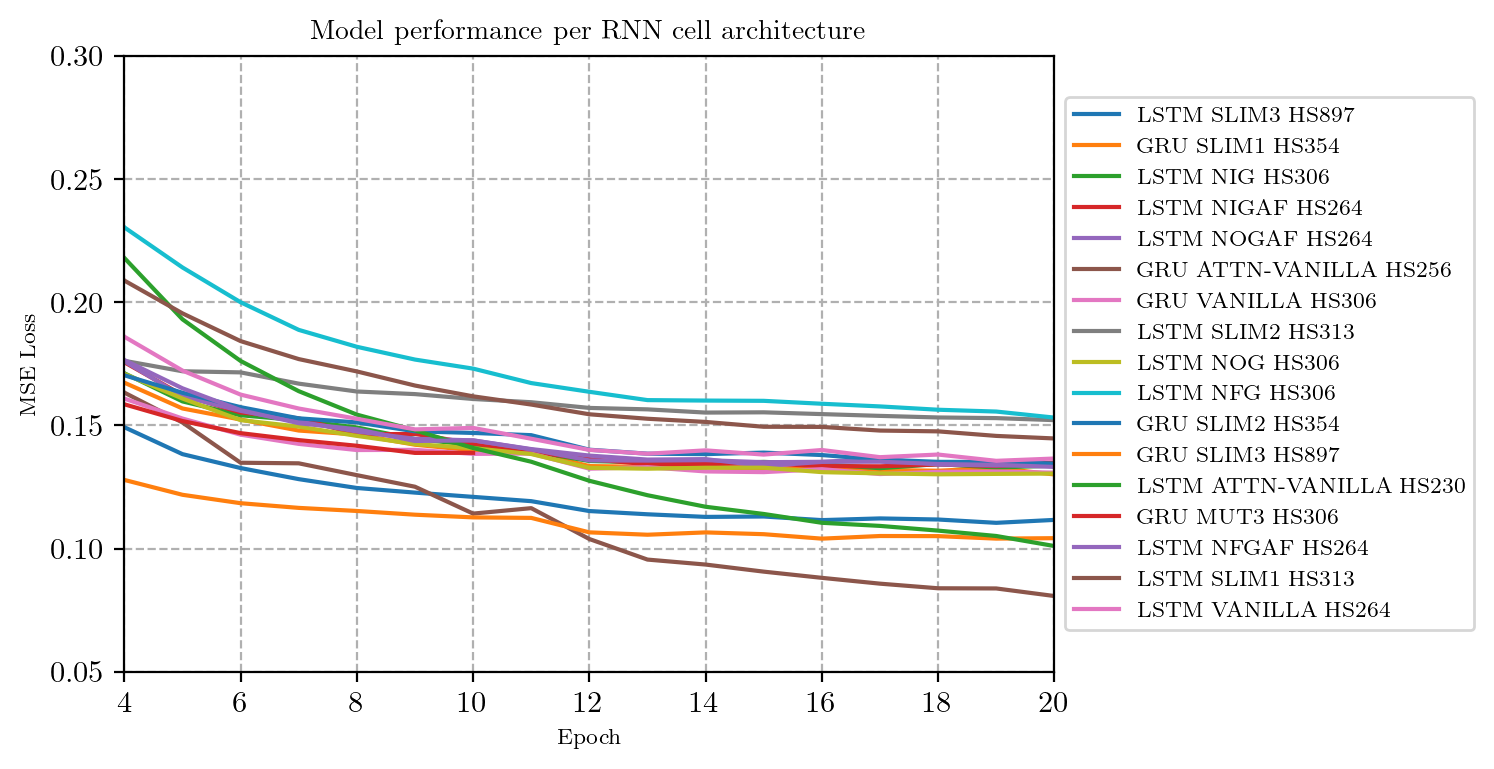

In [110]:

import matplotlib.pyplot as plt
folderpath = os.path.join(utils.cwd, 'models')

# Iterate over all elements in the folder
fig, ax = plt.subplots(figsize=(6,4))
for f in os.listdir(folderpath):

    # Check if it is a model file.
    if not os.path.isfile(os.path.join(folderpath, f)) or not \
        (f[:3]=='cef' and f.split('_')[-1]=='parameters'): continue
    
    filename = '_'.join(f.split('_')[1:-1])

    parameters = torch.load(os.path.join(folderpath, f'cef_{filename}_parameters'))

    epochs = parameters['learn_results']['epoch']
    loss = parameters['learn_results']['validation_loss']
    data = pd.Series(loss, epochs).drop_duplicates(keep='first')
    ax.plot(data, label = ' '.join(filename.split('_')[:3]).upper())

ax.set_title('Model performance per RNN cell architecture', fontsize=10)
ax.set_xlabel('Epoch', fontsize=8)
ax.set_ylabel('MSE Loss', fontsize=8)
ax.set_xlim(4, max(data.index))
ax.set_ylim(0.05,0.3)
ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True, linestyle='--')
    
